Simplest Palindrome with non-tied Dense.

Walk through pseudo-inverse and show how non-tied Dense are driven toward a pseudo-inverse relationship.

Try a kernel regularizer.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import nn
import keras
from keras import layers
from keras.datasets import mnist

Load up some MNIST digits

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
batch_size = 1024

Kernel regularizer that promotes a smaller determinant of the Gram matrix a pair of layers. This is truly a hare-brained scheme- this would be very hard to do in a model store/reload situation.

In [3]:
class PairDetRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, scaler):  # pylint: disable=redefined-outer-name
        self.scaler = scaler

    def wire(self, layer1, layer2):
        self.layer1 = layer1
        self.layer2 = layer2

    def __call__(self, x):
        # print('x', x)
        weights1 = tf.cast(self.layer1.trainable_weights[0], dtype='float64')
        weights2 = tf.cast(self.layer2.trainable_weights[0], dtype='float64')
        # print('weights1', weights1)
        # print('weights2', weights2)
        gram = tf.matmul(weights1, weights2)
        # print('gram', gram)
        loss = tf.sqrt(self.scaler * tf.abs(tf.linalg.det(gram)))
        # print('regularizer', loss)
        return loss


First, a basic 2-stage autoencoder for MNIST digits. Use all defaults, they're good. Leave out Bias, because we have no way to invert it yet.


In [4]:
def get_layer(model, name):
    for layer in model.layers:
        if layer.name == name:
            return layer

def create_palindromic_model(use_leaky=True, loss=True):
    input_img = keras.Input(shape=(784,))
    regularizer_a = PairDetRegularizer(1e28)
    regularizer_b = PairDetRegularizer(1e22)
    if loss:
        a = layers.Dense(128, use_bias=False, name='a', kernel_regularizer=regularizer_a)
        b = layers.Dense(64, use_bias=False, name='b') #, kernel_regularizer=regularizer_b)
        inv_b = layers.Dense(128, use_bias=False, name='inv_b') #, kernel_regularizer=regularizer_b)
        inv_a = layers.Dense(784, use_bias=False, name='inv_a', kernel_regularizer=regularizer_a)

        regularizer_a.wire(inv_a, a)
        # regularizer_b.wire(inv_b, b)
    else:
        a = layers.Dense(128, use_bias=False, name='a')
        b = layers.Dense(64, use_bias=False, name='b')
        inv_b = layers.Dense(128, use_bias=False, name='inv_b')
        inv_a = layers.Dense(784, use_bias=False, name='inv_a')

    x = a(input_img)
    if use_leaky:
        x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)
    x = b(x)
    x = inv_b(x)
    if use_leaky:
        x = layers.Lambda(lambda x: -x)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Lambda(lambda x: -x)(x)
    x = inv_a(x)

    autoencoder = keras.Model(input_img, x)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    return autoencoder, regularizer_a, regularizer_b

autoencoder, regularizer_a, regularizer_b = create_palindromic_model()
layer_a = get_layer(autoencoder, 'a')
print(dir(layer_a))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 a (Dense)                   (None, 128)               100352    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 b (Dense)                   (None, 64)                8192      
                                                                 
 inv_b (Dense)               (None, 128)               8192      
                                                                 
 lambda (Lambda)             (None, 128)               0     

In [5]:
class MonitorGram(tf.keras.callbacks.Callback):
    def __init__(self, forward, inverse):
        super(MonitorGram, self).__init__()
        self._forward = forward
        self._inverse = inverse
        self._grams = []

    def on_epoch_end(self, epoch, logs=None):
        forward = self._forward.get_weights()[0]
        inverse = self._inverse.get_weights()[0]
        gram = np.matmul(np.asarray(forward, dtype='float64'), np.asarray(inverse, dtype='float64'))
        det = np.linalg.det(gram)
        self._grams.append(det)

    def get_grams(self):
        return self._grams
        
class MonitorLoss(tf.keras.callbacks.Callback):
    def __init__(self, regularizer):
        super(MonitorLoss, self).__init__()
        self._regularizer = regularizer
        self._grams = []

    def on_epoch_end(self, epoch, logs=None):
        det = self._regularizer.__call__(None)
        self._grams.append(det)

    def get_grams(self):
        return self._grams

Now let's train it.

In [6]:
num_epochs =  300  # @param {type: "slider", min:2, max:1000}
autoencoder, regularizer_a, regularizer_b = create_palindromic_model()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
monitor_loss_a = MonitorLoss(regularizer_a)
# monitor_loss_b = MonitorLoss(regularizer_b)
monitor_gram_a = MonitorGram(get_layer(autoencoder, 'inv_a'), get_layer(autoencoder, 'a'))
# monitor_gram_b = MonitorGram(get_layer(autoencoder, 'inv_b'), get_layer(autoencoder, 'b'))

history = autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=2048,
                shuffle=True,
                callbacks=[early_stopping, monitor_loss_a, monitor_gram_a],
                validation_data=(x_test, x_test))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 a (Dense)                   (None, 128)               100352    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 b (Dense)                   (None, 64)                8192      
                                                                 
 inv_b (Dense)               (None, 128)               8192      
                                                                 
 lambda_2 (Lambda)           (None, 128)               0   

This is a terrible design, but it does work.

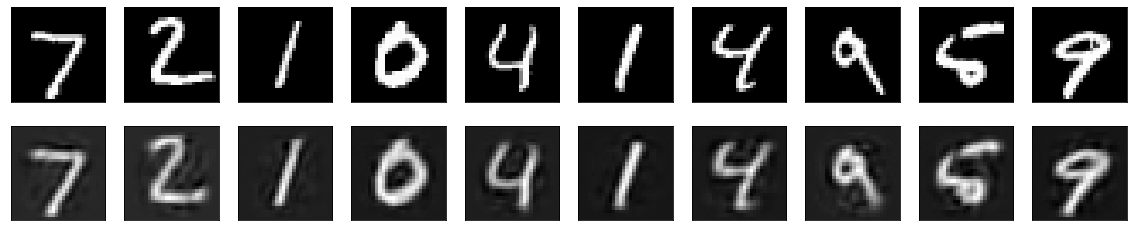

In [7]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

predicted_imgs = autoencoder.predict(x_test)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [8]:
def dual_plot(data1, data2, data3, name1, name2):
    assert len(data1) == len(data2)
    xaxis = [x for x in range(len(data1))]
    # create figure and axis objects with subplots()
    fig,ax = plt.subplots()
    # make a plot
    ax.plot(xaxis, data1,
            color="red")
    # set x-axis label
    ax.set_xlabel("epoch", fontsize = 14)
    # set y-axis label
    ax.set_ylabel(name1,
                color="red",
                fontsize=14)
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(xaxis, data2,color="blue")
    if data3 is not None:
        ax2.plot(xaxis, data3,color="green")
    ax2.set_ylabel(name2,color="blue",fontsize=14)
    plt.show()
    

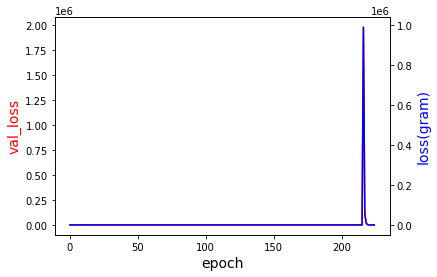

In [9]:
grams_a = monitor_loss_a.get_grams()
# grams_b = monitor_loss_b.get_grams()
# print(grams)
left = np.asarray(history.history['val_loss'], dtype='float64')
# left = np.abs(left[1:] - left[:-1])
right_a = np.abs(grams_a)
# right_b = np.abs(grams_b)
dual_plot(left, right_a, None, 'val_loss', 'loss(gram)')

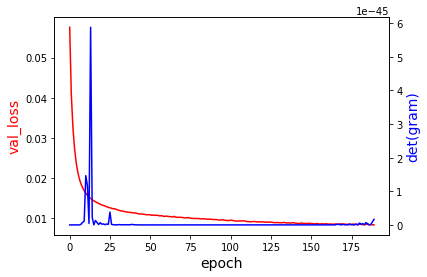

In [15]:
grams_a = monitor_gram_a.get_grams()
# print(grams)
left = np.asarray(history.history['val_loss'], dtype='float64')
# left = np.abs(left[1:] - left[:-1])
right_b = np.abs(grams_a)
left = left[:190]
right_b = right_b[:190]
dual_plot(left, right_b, None, 'val_loss', 'det(gram)')

Without loss

In [20]:
num_epochs =  300  # @param {type: "slider", min:2, max:1000}
autoencoder, regularizer_a, regularizer_b = create_palindromic_model(loss=False)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
monitor_gram_a = MonitorGram(get_layer(autoencoder, 'inv_a'), get_layer(autoencoder, 'a'))
monitor_gram_b = MonitorGram(get_layer(autoencoder, 'inv_b'), get_layer(autoencoder, 'b'))

history = autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=2048,
                shuffle=True,
                callbacks=[early_stopping, monitor_gram_a, monitor_gram_b], 
                validation_data=(x_test, x_test))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 a (Dense)                   (None, 128)               100352    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 b (Dense)                   (None, 64)                8192      
                                                                 
 inv_b (Dense)               (None, 128)               8192      
                                                                 
 lambda_8 (Lambda)           (None, 128)               0   

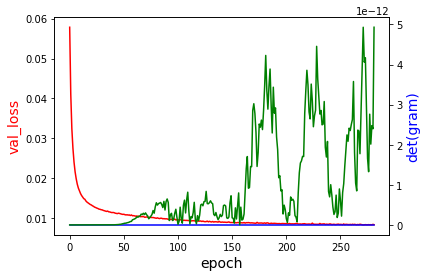

In [23]:
grams_a = monitor_gram_a.get_grams()
grams_b = monitor_gram_b.get_grams()
left = np.asarray(history.history['val_loss'], dtype='float64')
# left = np.abs(left[1:] - left[:-1])
right_a = np.abs(grams_a)
right_b = np.abs(grams_b)
dual_plot(left, right_a, right_b, 'val_loss', 'det(gram)')

In [ ]:
def get_layer(model, name):
    for layer in model.layers:
        if layer.name == name:
            return layer

def get_pair(model, forward, inverse):
    for layer in model.layers:
        if layer.name == forward:
            dense = layer
        elif layer.name == inverse:
            inverse_dense = layer
        
    weights = dense.get_weights()[0]
    print(len(weights))
    print('forward.shape', weights.shape)
    # print('b.shape', b.shape)
    inverse_weights = inverse_dense.get_weights()[0]
    print('inverse.shape', inverse_weights.shape)
    return np.asarray(weights, dtype='float64'), np.asarray(inverse_weights, dtype='float64')

def delta_gram(gram):
    print(gram.shape)
    ident = np.eye(gram.shape[0])
    return np.mean(np.abs(gram - ident))

def plot_gram(gram):
    fig, ax = plt.subplots()
    im = ax.imshow(gram)

In [ ]:
(forward, inverse) = get_pair(autoencoder, 'a', 'inv_a')
gram = np.matmul(inverse, forward)
print(delta_gram(gram))
print(np.linalg.det(gram))
plot_gram(gram)


In [ ]:
(forward, inverse) = get_pair(autoencoder, 'b', 'inv_b')
gram = np.matmul(inverse, forward)
print(delta_gram(gram))
print(np.linalg.det(gram))
plot_gram(gram)


In [ ]:
# untrained = create_palindromic_model()
# untrained.predict(x_test)
# (forward, inverse) = get_pair(untrained, 'a', 'inv_a')
# gram = np.matmul(inverse, forward)
# print(delta_gram(gram))
# print(np.linalg.det(gram))
# plot_gram(np.sqrt(gram))

In [ ]:
# gram = np.matmul(inverse, np.transpose(inverse))
# print(np.linalg.det(gram))
# plot_gram(np.sqrt(gram))

In [ ]:
# def create_palindromic_model():
#     kernel_init = 'glorot_uniform'
#     input_img = keras.Input(shape=(784,))
#     x = layers.Dense(128, kernel_initializer=kernel_init, use_bias=False, name='a')(input_img)
#     x = layers.Dense(64, kernel_initializer=kernel_init, use_bias=False, name='b')(x)
#     # x = layers.Dense(32, use_bias=False)(x)
#     # x = layers.Dense(64, use_bias=False)(x)
#     x = layers.Dense(128, kernel_initializer=kernel_init, use_bias=False, name='inv_b')(x)
#     x = layers.Dense(784, kernel_initializer=kernel_init, use_bias=False, name='inv_a')(x)

#     autoencoder = keras.Model(input_img, x)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     autoencoder.summary()
#     return autoencoder

In [ ]:
num_epochs =  300  # @param {type: "slider", min:2, max:300}
autoencoder, _, _ = create_palindromic_model()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
# monitor_gram = MonitorLoss(get_layer(autoencoder, 'inv_b'), get_layer(autoencoder, 'b'))

history = autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=2048,
                shuffle=True,
                callbacks=[early_stopping],
                validation_data=(x_test, x_test))

In [ ]:
print(history)

In [ ]:
grams = monitor_gram.get_grams()
print(grams)

In [ ]:
plt.plot(range(len(grams)), np.abs(grams))

In [ ]:
left = np.asarray(history.history['val_loss'], dtype='float64')
# left = np.abs(left[1:] - left[:-1])
right = np.abs(grams)
dual_plot(left, right, 'val_loss', 'det(gram)')

In [ ]:
(forward, inverse) = get_pair(autoencoder, 'inv_b', 'b')
gram = np.matmul(inverse, forward)
print(delta_gram(gram))
print(np.linalg.det(gram))
plot_gram(np.sqrt(np.abs(gram)))
# plot_gram(np.abs(gram))

In [ ]:
plot_gram(gram)

In [ ]:
plot_gram(np.sqrt(gram))

In [ ]:
print(grams[-1])

In [ ]:
(forward, inverse) = get_pair(autoencoder, 'inv_b', 'b')


In [ ]:
ones = np.ones((forward.shape[0],), dtype='float64')
print(ones.shape)
projected = np.matmul(ones, forward)
print(projected.shape)
print(projected)

In [ ]:
inverted = np.matmul(projected, inverse)
print(inverted.shape)
print(inverted)